In [22]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import linregress
pd.set_option('precision', 2)

In [23]:
race_list = []
suffix_list = []
for year in ['2018','2019','2020','2021','2022']:
    for race_name in ['BUCS_XC','National_XC','IC','MK','Liverpool']:
        try:
            fp = '../data/Men/'+race_name+'_'+year+'.csv'
            race_list.append(pd.read_csv(fp))
            suffix_list.append(str.lower(race_name[:2])+year[-2:])
        except FileNotFoundError:
            #print(fp)
            pass

In [24]:
race_list = [df.drop(columns='raw_time') for df in race_list]

for i,df in enumerate(race_list):
    df.rename(columns = {'position':'position_'+suffix_list[i]}, inplace = True)

In [25]:
complete = pd.merge(race_list[0],race_list[1],how='outer',on='raw_name')
for x in race_list[2:]:
    complete = pd.merge(complete,x,how='outer',on='raw_name')
    
raw_name = complete.pop('raw_name')
complete.insert(0,"raw_name",raw_name)

In [26]:
#for inclusion you need to have come inside the top 50 somewhere
complete = complete[complete.min(axis=1)<50]

In [27]:
def get_rating(df,input_data_col,new_result_col,sfx=' '):
    df_overlap = df[~df[input_data_col].isnull()&~df[new_result_col].isnull()]
    
    sol = linregress(df_overlap[input_data_col],df_overlap[new_result_col])
    m = sol.slope
    c = sol.intercept
    space_min = df_overlap[input_data_col].min()-100
    space_max = df_overlap[input_data_col].max()+100
    
    quantile = (df_overlap[input_data_col]*m+c - df_overlap[new_result_col]).abs().quantile(q=0.67)
    
    plt.figure()
    plt.plot(np.linspace(space_min,space_max),np.linspace(space_min,space_max)*m+c)
    plt.scatter(df_overlap[input_data_col],df_overlap[new_result_col])
    plt.title(sfx + ', q=' + str(np.round(quantile,0)))
    
    return ((df[new_result_col])-c)/m

def update_with_suffix(complete,sfx,keep_position=True):
    complete['rating_'+sfx] = get_rating(complete,'rating','position_'+sfx,sfx)
    #weighted mean as final iteration
    complete = complete.assign(rating=complete.loc[:, ['rating','rating_'+sfx]].mean(axis=1))
    if not keep_position:
        complete = complete.drop(columns='position_'+sfx)
    return complete

In [28]:
if True:
    complete['rating'] =  2500 - (complete.position_na18 - 1) * 1
    complete["rating_na18"] = complete.rating
    complete = complete.drop(columns='position_na18')

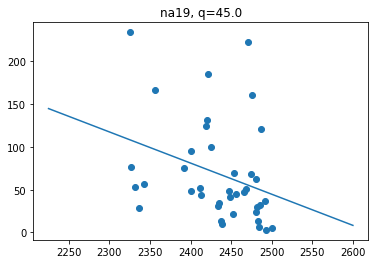

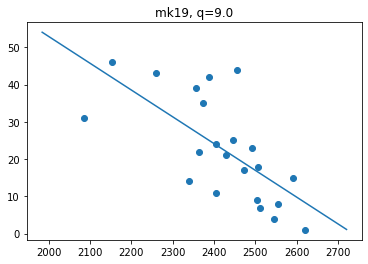

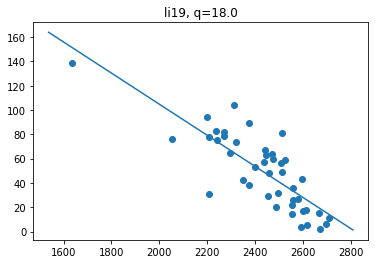

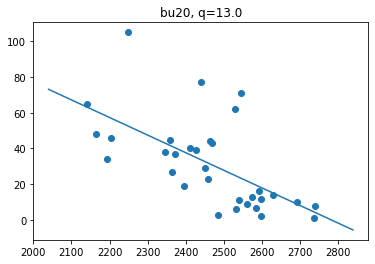

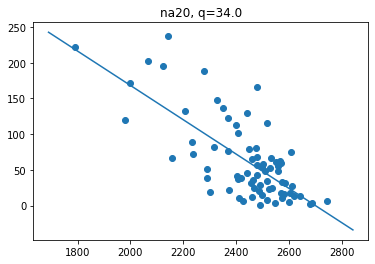

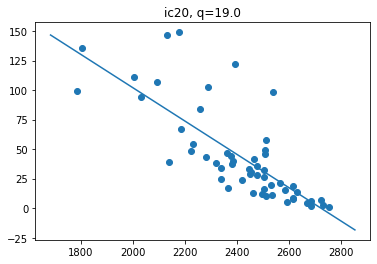

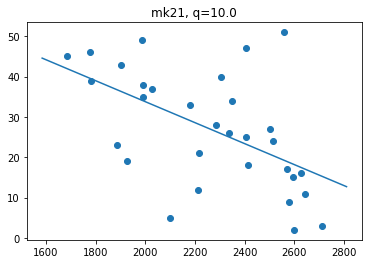

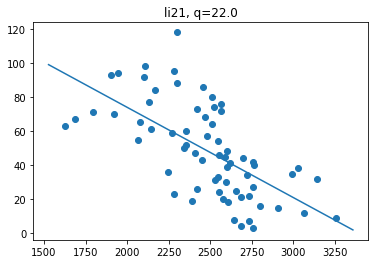

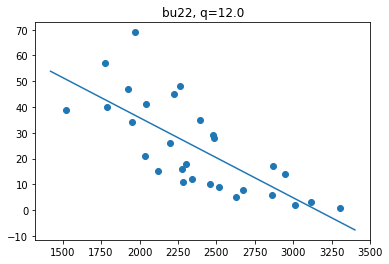

In [29]:
for suffix in suffix_list[1:]:
    complete = update_with_suffix(complete,suffix)

In [30]:
bucs_only = complete[~complete.rating_bu22.isna()]
bucs_only = bucs_only.sort_values("rating_bu22",ascending=False)

In [18]:
bucs_only[["raw_name","rating_mk21","rating_li21","rating_bu22","rating"]].head(30)

,raw_name,rating_mk21,rating_li21,rating_bu22,rating
845,William Battershill,NaN,3301.57,3122.34,3211.96
751,Zakariya Mahamed,3221.75,3112.76,3090.16,3050.55
792,Matthew Stonier,3068.02,3169.40,3057.98,3088.35
917,Will Barnicoat,NaN,NaN,3025.80,3025.80
493,Michael Ward,NaN,NaN,2993.62,2809.97
794,Joe Hudson,2991.16,2735.13,2961.44,2912.29
918,Joshua Dickinson,NaN,NaN,2929.27,2929.27
798,Alex Ediker,2529.97,2810.65,2897.09,2783.70
799,Ned Potter,2453.11,2584.07,2864.91,2691.75
496,Cameron Allan,NaN,2508.55,2832.73,2646.48


Text(0, 0.5, 'Finish position at BUCS 2022')

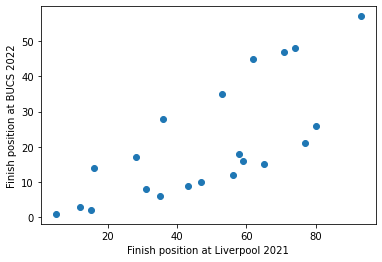

In [38]:
plt.scatter(bucs_only.position_li21,bucs_only.position_bu22)
plt.xlabel('Finish position at Liverpool 2021')
plt.ylabel('Finish position at BUCS 2022')

In [35]:
bucs_only[["raw_name","position_li21","position_bu22"]][~bucs_only.position_li21.isna()]

,raw_name,position_li21,position_bu22
845,William Battershill,5.0,1.0
751,Zakariya Mahamed,15.0,2.0
792,Matthew Stonier,12.0,3.0
794,Joe Hudson,35.0,6.0
798,Alex Ediker,31.0,8.0
799,Ned Potter,43.0,9.0
496,Cameron Allan,47.0,10.0
858,Tomer Tarragano,56.0,12.0
796,Sam Charlton,16.0,14.0
366,James Edgerton,65.0,15.0
